In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ''

from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()


2024-10-07 09:27:32.139577: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 09:27:35.201781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-07 09:27:35.202090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-07 09:27:35.202107: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [91]:
from encoding_information.datasets import ColorFilterArrayDataset
from cleanplots import *
from tqdm import tqdm

tile_size = 128

dataset = ColorFilterArrayDataset('/home/hpinkard_waller/data/four_channel_images.zarr', tile_size=tile_size)

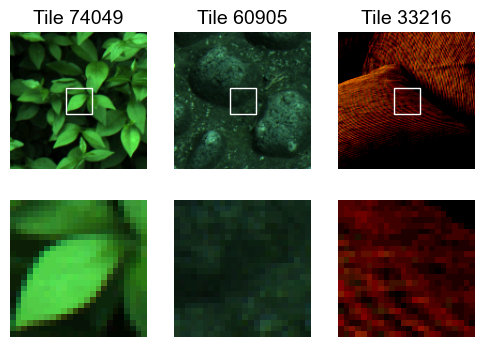

In [101]:
from matplotlib.patches import Rectangle

# Find tiles that look good to show as objects

# for i in tqdm(range(5)):

num_to_show = 10
center_square_size = 24
# brightness = 6

# indices = np.random.randint(0, dataset._tiles.shape[0], num_to_show)

if tile_size == 128:
    # these were good for 128x128 tiles
    # indices = [2084, 74049, 60905, 11205, 1197, 80825, 41626, 33216, 18083]
    indices = [74049, 60905, 33216]
elif tile_size == 64:
    # 64x64 tiles
    indices = [172324, 351278, 347857, 54000, 16118, 171456]
else:
    raise ValueError("No indices for this tile size")

tiles = dataset._tiles[indices]
tiles = tiles[..., :3] # remove gray

# rescale each tile to max 255
# tiles = [tile * 255 / np.max(tile) for tile in tiles]
tiles = [(tile - np.min(tile)) / (np.max(tile) - np.min(tile)) * 255 for tile in tiles]

# clip 
tiles = np.clip(tiles, 0, 255)


# tile_size = 96
# tiles = [tile[:96, :96] for tile in tiles]

# plot tile
fig, ax = plt.subplots(2, len(tiles), figsize=(2 * len(tiles), 4))
for i in range(len(tiles)):
    ax[0, i].imshow(tiles[i].astype(np.uint8))
    ax[0, i].set(title=f"Tile {indices[i]}")
    # add a patch for a center square
    ax[0, i].add_patch(Rectangle((tile_size // 2 - center_square_size // 2, tile_size // 2 - center_square_size // 2), center_square_size, 
                center_square_size, edgecolor='white', facecolor='none'))
    ax[0, i].axis('off')
    
    crop = tiles[i][tile_size // 2 - center_square_size // 2:tile_size // 2 + center_square_size // 2, 
                    tile_size // 2 - center_square_size // 2:tile_size // 2 + center_square_size // 2]
    ax[1, i].imshow(crop.astype(np.uint8))
    ax[1, i].axis('off')

fig.savefig('/home/hpinkard_waller/figures/bayer/objects.pdf', transparent=True)

# TODO: what mean are you actually using?

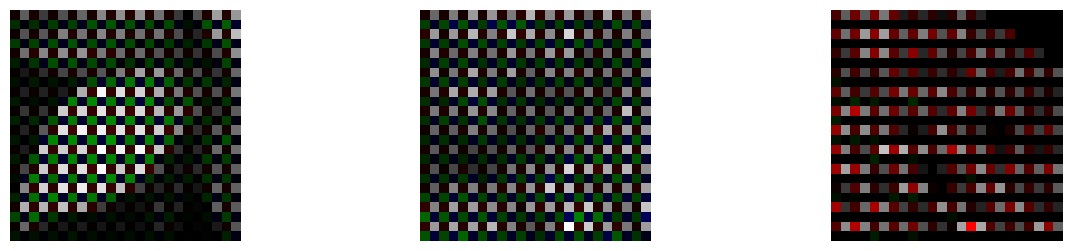

In [100]:
# Plot measurements with noise

filter_matrix = np.array([[0, 3], [1, 2]])

# TODO: what mean are you actually using?
measurements = dataset.get_measurements(mean=150, bias=0, tile_indices=indices, filter_matrix=filter_matrix)

h, w = measurements[0].shape
filter_h, filter_w = filter_matrix.shape
tiled_filter = np.tile(filter_matrix, (h // filter_h, h // filter_w))

# convert back to RGB
red_image = (tiled_filter == 0) * measurements
green_image = (tiled_filter == 1) * measurements
blue_image = (tiled_filter == 2) * measurements
white_mask = tiled_filter == 3

# combine into RGB image
colored_measurements = np.stack([red_image, green_image, blue_image], axis=-1)
# add white channel
colored_measurements[:, white_mask] = measurements[:, white_mask][..., None]


# crop to central square
edge_crop = (colored_measurements.shape[1] - center_square_size) // 2
crops = [colored_measurement[edge_crop:-edge_crop, edge_crop:-edge_crop] for colored_measurement in colored_measurements]


# convert to int and clip
# rescale to max 255
colored_measurements = [colored_measurement / np.max(colored_measurement) for colored_measurement in crops]
colored_measurements = np.clip(colored_measurements, 0, 1)


# plot measurements
fig, ax = plt.subplots(1, len(tiles), figsize=(5 * len(tiles), 3))
for i in range(len(tiles)):
    ax[i].imshow(colored_measurements[i], interpolation='none')
    ax[i].axis('off')

fig.savefig('/home/hpinkard_waller/figures/bayer/measurements.pdf', transparent=True)

Text(0.5, 0.98, 'Zoomed in patches')

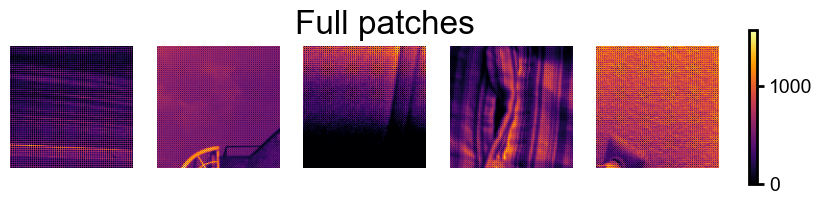

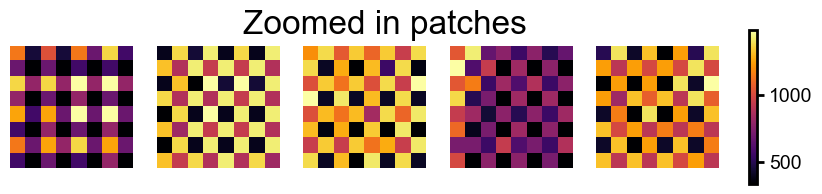

In [5]:
from encoding_information.datasets import ColorFilterArrayDataset
from cleanplots import *

dataset = ColorFilterArrayDataset('/home/hpinkard_waller/data/four_channel_images.zarr', tile_size=128)

bayer_filter = [[0, 1], [1, 2]]

measurements = dataset.get_measurements(num_measurements=10, filter_matrix=bayer_filter, noise=None, data_seed=1253)

vmin, vmax = None, None

fig, ax = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    im = ax[i].imshow(measurements[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax[i].axis('off')

# show colorbar off to right side
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.suptitle('Full patches')

zoom_patch_size = 8
# Zoom in to see the filter pattern
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    im = ax[i].imshow(measurements[i][:zoom_patch_size, :zoom_patch_size], cmap='inferno', vmin=vmin, vmax=vmax)
    ax[i].axis('off')

# show colorbar off to right side
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.suptitle('Zoomed in patches')
